In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split 
import seaborn as sns
from matplotlib import pyplot as plt

# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
import tensorboard
tensorboard.__version__

2023-02-08 14:12:52.665887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version:  2.10.0


'2.10.0'

### Import and Understand the Data
I am working with the vehicle emissions data found at 
https://sumo.dlr.de/docs/Simulation/Output/EmissionOutput.html

The imported column values are:
time_step,
ID,
eclass,
CO2,
CO,
HC,
NOx,
PMx,
fuel,
electricity,
noise - in dB,
route - name of the route,
type - name of the vehicle,
waiting,
lane - the name of the lane where the vehicle is moving,
pos - position,
speed,
angle - the vehicles angle,
pos_x - the absolute x coordinate,
pos_y - the absolute y coordinate

In [2]:
emission_train = pd.read_csv("emission.csv", delimiter=",", quoting = 3, nrows=12000000)

In [3]:
# Next, I want to see an example of the data I am working with to ensure it was imported properly.
display(emission_train.head(100))

# I also want to view some descriptive statistics to look for the possibility of outliers, the bulk of where the
# data lies, and further explanation of the data.
display(emission_train.describe())

,timestep_time,vehicle_CO,vehicle_CO2,vehicle_HC,vehicle_NOx,vehicle_PMx,vehicle_angle,vehicle_eclass,vehicle_electricity,vehicle_fuel,vehicle_id,vehicle_lane,vehicle_noise,vehicle_pos,vehicle_route,vehicle_speed,vehicle_type,vehicle_waiting,vehicle_x,vehicle_y
0,0.0,15.20,7380.56,0.00,84.89,2.21,50.28,HBEFA3/HDV,0.0,3.13,truck0,5329992#5_0,67.11,7.20,!truck0!var#1,0.00,truck_truck,0.0,18275.04,26987.78
1,0.0,0.00,2416.04,0.01,0.72,0.01,42.25,HBEFA3/PC_G_EU4,0.0,1.04,veh0,5330181#0_0,65.15,5.10,!veh0!var#1,14.72,veh_passenger,0.0,18279.94,24533.12
2,1.0,17.92,9898.93,0.00,103.38,2.49,50.28,HBEFA3/HDV,0.0,4.20,truck0,5329992#5_0,73.20,8.21,!truck0!var#1,1.01,truck_truck,0.0,18275.82,26988.43
3,1.0,0.00,0.00,0.00,0.00,0.00,42.25,HBEFA3/PC_G_EU4,0.0,0.00,veh0,5330181#0_0,62.72,18.85,!veh0!var#1,13.75,veh_passenger,0.0,18289.19,24543.30
4,1.0,164.78,2624.72,0.81,1.20,0.07,357.00,HBEFA3/PC_G_EU4,0.0,1.13,veh1,-5338968#2_0,55.94,5.10,!veh1!var#1,0.00,veh_passenger,0.0,29252.01,24424.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.0,23.44,2578.06,0.15,0.64,0.05,0.13,HBEFA3/LDV_G_EU6,0.0,1.11,moto2,-5341858#10_0,63.24,35.78,!moto2!var#1,11.62,moto_motorcycle,0.0,26468.26,25548.47
96,7.0,732.32,18759.70,3.34,3.79,1.19,179.93,HBEFA3/LDV_G_EU6,0.0,8.07,moto3,-342586098#36_0,81.67,30.96,!moto3!var#1,13.99,moto_motorcycle,0.0,24729.15,27450.68
97,7.0,294.68,6949.38,1.29,1.47,0.43,179.93,HBEFA3/LDV_G_EU6,0.0,2.99,moto4,5331636#0_0,72.45,11.88,!moto4!var#1,6.37,moto_motorcycle,0.0,29159.96,25066.29
98,7.0,236.07,4292.19,0.97,0.93,0.30,1.91,HBEFA3/LDV_G_EU6,0.0,1.85,moto5,5340657#0_0,71.73,5.60,!moto5!var#1,3.30,moto_motorcycle,0.0,24340.58,28198.87


,timestep_time,vehicle_CO,vehicle_CO2,vehicle_HC,vehicle_NOx,vehicle_PMx,vehicle_angle,vehicle_electricity,vehicle_fuel,vehicle_noise,vehicle_pos,vehicle_speed,vehicle_waiting,vehicle_x,vehicle_y
count,1.200000e+07,1.200000e+07,1.200000e+07,1.200000e+07,1.200000e+07,1.200000e+07,1.200000e+07,12000000.0,1.200000e+07,1.200000e+07,1.200000e+07,1.200000e+07,1.200000e+07,1.200000e+07,1.200000e+07
mean,3.128849e+03,5.858480e+01,4.845348e+03,6.600635e-01,1.653887e+01,3.922944e-01,1.636250e+02,0.0,2.074021e+00,6.629458e+01,2.107929e+02,1.345480e+01,3.035752e+00,2.452260e+04,2.496371e+04
std,1.576951e+03,9.008204e+01,7.892427e+03,1.479879e+00,5.903701e+01,1.135593e+00,1.050156e+02,0.0,3.360559e+00,7.402037e+00,5.759736e+02,8.764449e+00,1.736109e+01,3.977453e+03,3.013466e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.258000e+01,0.000000e+00,0.000000e+00,0.000000e+00,9.960000e+00,-1.490000e+00
25%,1.790000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.031000e+01,0.0,0.000000e+00,6.239000e+01,2.373000e+01,6.990000e+00,0.000000e+00,2.216160e+04,2.347998e+04
50%,3.162000e+03,2.017000e+01,2.624720e+03,1.300000e-01,1.200000e+00,5.000000e-02,1.800000e+02,0.0,1.130000e+00,6.710000e+01,7.189000e+01,1.344000e+01,0.000000e+00,2.390369e+04,2.543757e+04
75%,4.498000e+03,1.059400e+02,6.149550e+03,7.400000e-01,2.590000e+00,1.400000e-01,2.703600e+02,0.0,2.640000e+00,7.108000e+01,1.773300e+02,2.006000e+01,0.000000e+00,2.682936e+04,2.673204e+04
max,5.794000e+03,3.932950e+03,1.153026e+05,1.729000e+01,8.864200e+02,1.432000e+01,3.600000e+02,0.0,4.888000e+01,1.019600e+02,1.943554e+04,4.997000e+01,3.970000e+02,4.492832e+04,4.753314e+04


12000000 emission_train
600000 correlation_graph_data


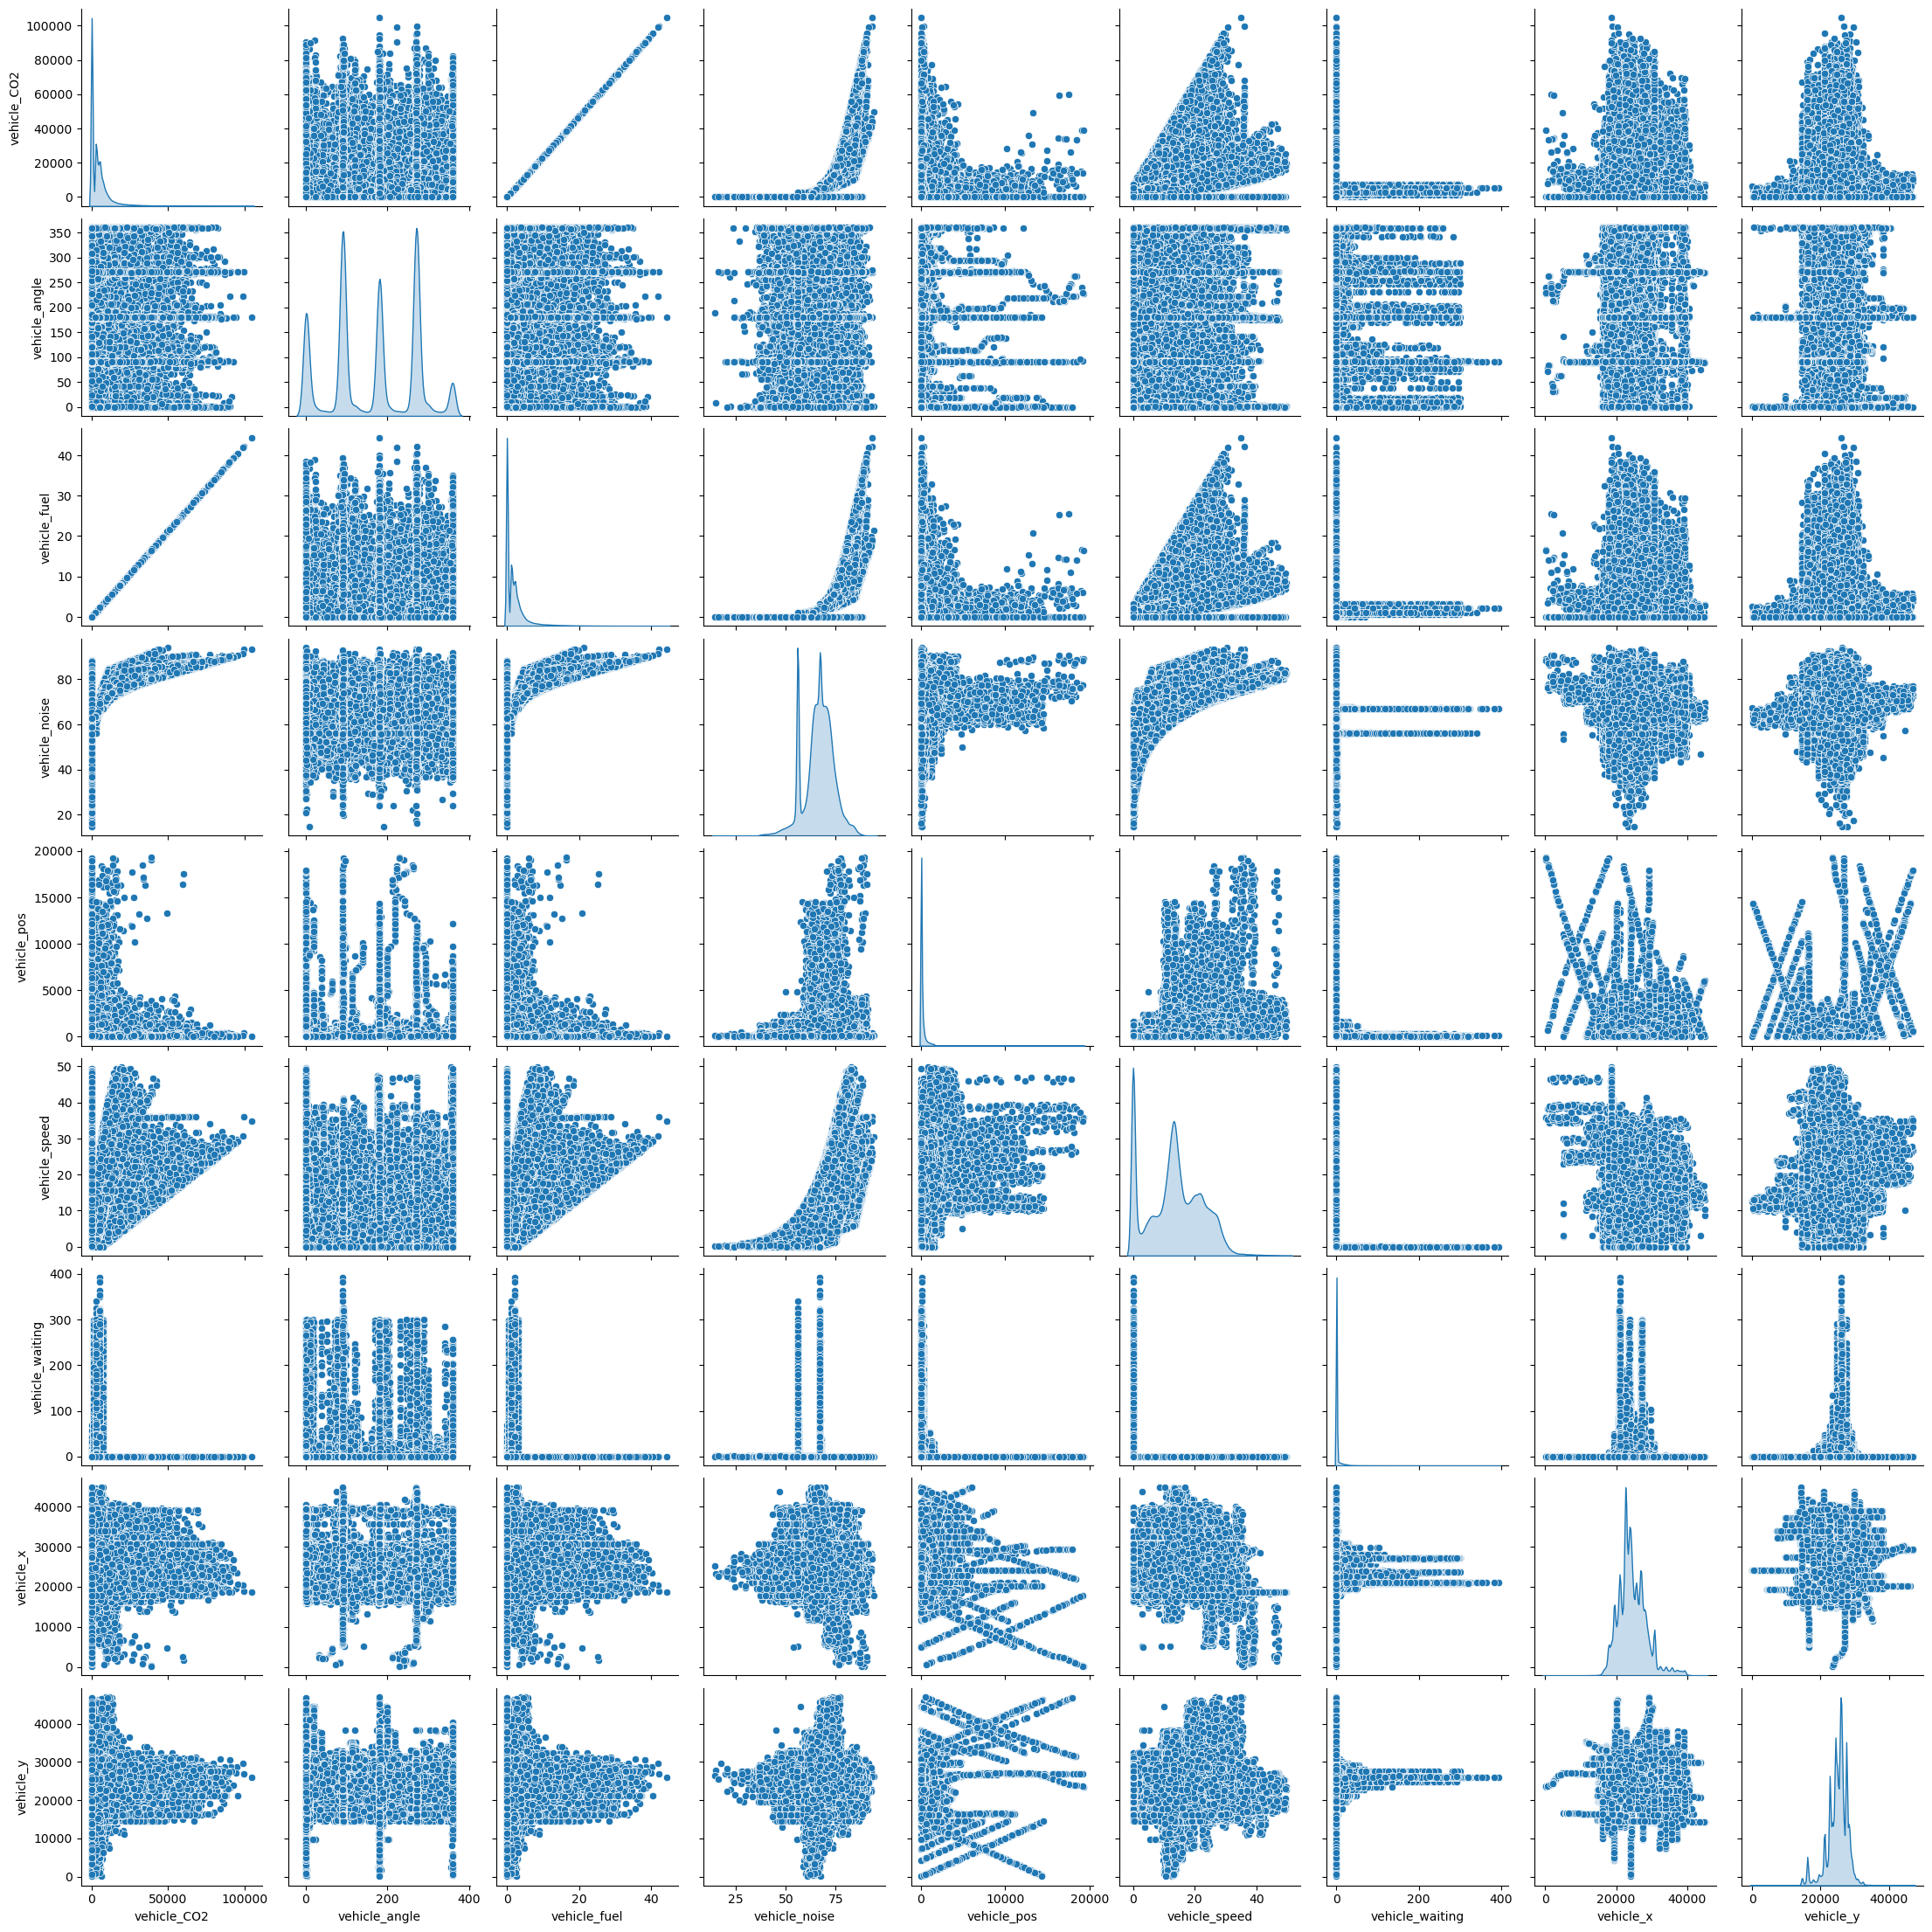

In [4]:
#It can also be helpful to view correlation datasets visually to look for columns that may have stronger
#correlations to each other.

correlation_graph_data = emission_train.sample(frac=0.05).reset_index(drop=True)
print(len(emission_train), 'emission_train')
print(len(correlation_graph_data), 'correlation_graph_data')

sns.pairplot(correlation_graph_data[['vehicle_CO2', 'vehicle_angle', 'vehicle_fuel', 'vehicle_noise', 'vehicle_pos', 'vehicle_speed', 'vehicle_waiting', 'vehicle_x', 'vehicle_y']], diag_kind='kde')
del correlation_graph_data

#In this case we can see that several features have linear relationships, some have exponential relationships,
#others appear not to be strongly related.

### Clean up the Dataset
This dataset is already mostly clean, but for the purposes of machine learning, it has many features that will not be helpful to us, and contains NaN values. It is at this point that we will want to remove data that will not be useful for the purpose of prediction. This can be done in many ways but first of all, since we are only predicting vehicle CO2, we can remove the other emissions. The case could also be made that the other emission classes could have relationships with CO2 production, but that relationship would be confounding as it can be expected that, due to the nature of combustion, that with CO2 production we will also have CO, HC, NOx, and PMx. The computer may learn to just estimate the other emissions production which we do not want.

Further, we can also get rid of the timestep_time, vehicle_id, vehicle_angle, vehicle_lane, vehicle_pos, vehicle_route, vehicle_x, and vehicle_y. These are removed as they do not effect the CO2 production and increase training time and complexity. This decision was concluded after viewing the correlational graphs as well as experimenting with feature input during the training process. Vehicle electricity was also removed as it reduced the models overall accuracy in both the validation and test sets.

In [5]:
emission_train = emission_train.drop(columns=["vehicle_CO", "vehicle_HC", "vehicle_NOx", "vehicle_PMx", "vehicle_angle",
                                              "timestep_time", "vehicle_id", "vehicle_lane", "vehicle_pos",
                                             "vehicle_route", "vehicle_x", "vehicle_y", "vehicle_electricity"])

for header in ["vehicle_eclass", "vehicle_type"]:
    emission_train[header] = emission_train[header].astype(str)

# Remove NaNs
emission_train = emission_train.dropna().reset_index(drop=True)

# Shuffle the dataset
emission_train_shuffle = emission_train.sample(frac=1)

## Split Data for Machine Learning
Next, the data is split into training, validation and test sets for machine learning.

In [6]:
train_df, backup_df = train_test_split(emission_train_shuffle, test_size=0.99) # Comment this line for large data training

#train_df, test_df = train_test_split(emission_train_shuffle, test_size=0.1) # Uncomment for large dataset
train_df, test_df = train_test_split(train_df, test_size=0.1) # Comment for large dataset
train_df, val_df = train_test_split(train_df, test_size=0.2)

print(len(train_df), 'train examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples')

del emission_train

86400 train examples
21600 validation examples
12000 test examples


### Organize Features
Next, I have organized the input features into either numerical or categorical. This tells tensorflow which type of data it will be working with during training. Our feature layer can then be created.

In [7]:
feature_cols = []

# Numeric Columns
for header in ["vehicle_fuel", "vehicle_speed", "vehicle_waiting", "vehicle_noise"]:
    num_cols = tf.feature_column.numeric_column(key = header)
    feature_cols.append(num_cols)

# Indicator Columns
indicator_col_names = ["vehicle_eclass", "vehicle_type"]
for col_name in indicator_col_names:
    categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(col_name, 
                                            train_df[col_name].unique())
    indicator_column = tf.feature_column.indicator_column(categorical_column)
    feature_cols.append(indicator_column)

# Create a feature layer for tf
feature_layer = tf.keras.layers.DenseFeatures(feature_cols, name='Features')

### Create and Train the Model
For this project I am using a general ANN model which utilizes the optimizer Adam, and the mean squared error metric for the loss function. As a final step I implemented the softplus activation layer which implements the softmax function.

After testing, I have found a 4-layer system (24, 16, 11, 5 units respectively), with a batch size of , and a learning rate of 0.00024, resulted in model convergence and reliable validation and test data prediction.

In [8]:
# Hyperparameters
learning_rate = 0.00024
epochs = 150
batch_size = 250

# Label 
label_name = "vehicle_CO2"
shuffle = True

#---Create a sequential model---#
model = tf.keras.models.Sequential([
    feature_layer,
    # Hidden Layers
    tf.keras.layers.Dense(units=24, 
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l1(l=0.03),
                          name='Hidden1'),
    tf.keras.layers.Dense(units=16, 
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l1(l=0.03),
                          name='Hidden2'),
    tf.keras.layers.Dense(units=11, 
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l1(l=0.03),
                          name='Hidden3'),
    tf.keras.layers.Dense(units=5, 
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l1(l=0.027),
                          name='Hidden4'),
    # Output layer
    tf.keras.layers.Dense(units=1,  
                          activation='softplus',
                          name='Output')

])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

#---Train the Model---#
# Keras TensorBoard callback.
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

train_lbl = np.array(train_df["vehicle_CO2"])
train_df = train_df.drop(columns=["vehicle_CO2"])
# Split the datasets into features and label.
train_ft = {name:np.array(value) for name, value in train_df.items()}
# train_lbl = np.array(train_ft.pop(label_name))

val_lbl =  np.array(val_df["vehicle_CO2"])
val_df = val_df.drop(columns=["vehicle_CO2"])
val_ft = {name:np.array(value) for name, value in val_df.items()}


# Keras TensorBoard callback.
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(x=train_ft, y=train_lbl, batch_size=batch_size,
          epochs=epochs, callbacks=[tensorboard_callback], validation_data=(val_ft, val_lbl), shuffle=shuffle)

# Training function for large training set
#model.fit(x=train_ft, y=train_lbl, batch_size=batch_size,
#           epochs=epochs, verbose=1, validation_data=(val_ft, val_lbl), shuffle=shuffle, callbacks=[tensorboard_callback])

Epoch 1/150


2023-02-08 14:14:46.812407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 14:14:46.814921: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/michael/anaconda3/envs/ml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


346/346 [==============================] - 2s 6ms/step - loss: 84816248.0000 - mse: 84816248.0000 - val_loss: 82156464.0000 - val_mse: 82156464.0000
Epoch 2/150
346/346 [==============================] - 2s 4ms/step - loss: 68991928.0000 - mse: 68991928.0000 - val_loss: 58146384.0000 - val_mse: 58146384.0000
Epoch 3/150
346/346 [==============================] - 2s 5ms/step - loss: 55089652.0000 - mse: 55089648.0000 - val_loss: 54001924.0000 - val_mse: 54001920.0000
Epoch 4/150
346/346 [==============================] - 2s 5ms/step - loss: 51636592.0000 - mse: 51636584.0000 - val_loss: 49995268.0000 - val_mse: 49995256.0000
Epoch 5/150
346/346 [==============================] - 2s 5ms/step - loss: 45862016.0000 - mse: 45862012.0000 - val_loss: 41425112.0000 - val_mse: 41425096.0000
Epoch 6/150
346/346 [==============================] - 2s 6ms/step - loss: 32031446.0000 - mse: 32031436.0000 - val_loss: 21614018.0000 - val_mse: 21614010.0000
Epoch 7/150
346/346 [=========================

Epoch 47/150
346/346 [==============================] - 2s 5ms/step - loss: 821.8057 - mse: 811.4479 - val_loss: 788.4421 - val_mse: 778.0718
Epoch 48/150
346/346 [==============================] - 2s 6ms/step - loss: 801.5026 - mse: 791.1210 - val_loss: 766.3238 - val_mse: 755.9297
Epoch 49/150
346/346 [==============================] - 2s 5ms/step - loss: 755.3799 - mse: 744.9739 - val_loss: 717.3517 - val_mse: 706.9332
Epoch 50/150
346/346 [==============================] - 2s 6ms/step - loss: 706.6241 - mse: 696.1962 - val_loss: 675.4052 - val_mse: 664.9675
Epoch 51/150
346/346 [==============================] - 2s 7ms/step - loss: 650.5570 - mse: 640.1084 - val_loss: 657.3953 - val_mse: 646.9336
Epoch 52/150
346/346 [==============================] - 2s 6ms/step - loss: 628.7762 - mse: 618.3053 - val_loss: 685.6329 - val_mse: 675.1524
Epoch 53/150
346/346 [==============================] - 2s 5ms/step - loss: 574.3893 - mse: 563.9001 - val_loss: 554.4871 - val_mse: 543.9799
Epoch 

346/346 [==============================] - 2s 5ms/step - loss: 133.8083 - mse: 122.9126 - val_loss: 137.1469 - val_mse: 126.2519
Epoch 105/150
346/346 [==============================] - 2s 6ms/step - loss: 135.4251 - mse: 124.5298 - val_loss: 176.0381 - val_mse: 165.1433
Epoch 106/150
346/346 [==============================] - 2s 6ms/step - loss: 132.5872 - mse: 121.6922 - val_loss: 120.7423 - val_mse: 109.8480
Epoch 107/150
346/346 [==============================] - 2s 5ms/step - loss: 134.2351 - mse: 123.3409 - val_loss: 125.3067 - val_mse: 114.4131
Epoch 108/150
346/346 [==============================] - 2s 6ms/step - loss: 181.0705 - mse: 170.1790 - val_loss: 135.3818 - val_mse: 124.4907
Epoch 109/150
346/346 [==============================] - 2s 6ms/step - loss: 121.7341 - mse: 110.8410 - val_loss: 166.7270 - val_mse: 155.8323
Epoch 110/150
346/346 [==============================] - 2s 6ms/step - loss: 126.4715 - mse: 115.5763 - val_loss: 160.9132 - val_mse: 150.0182
Epoch 111/150

### Evaluate the Model with Test Data
As a final step, I have implemented several charts to view the models ability to predict CO2 vehicle emissions.

In [9]:
test_lbl = np.array(test_df["vehicle_CO2"])
test_df = test_df.drop(columns=["vehicle_CO2"])
test_ft = {key:np.array(value) for key, value in test_df.items()}
print("Model evaluation: \n")
model.evaluate(x=test_ft, y=test_lbl, batch_size=batch_size)

Model evaluation: 

48/48 [==============================] - 0s 3ms/step - loss: 102.5536 - mse: 91.6527


[102.55359649658203, 91.6527099609375]

In [10]:
# Get a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Features (DenseFeatures)    multiple                  0         
                                                                 
 Hidden1 (Dense)             multiple                  336       
                                                                 
 Hidden2 (Dense)             multiple                  400       
                                                                 
 Hidden3 (Dense)             multiple                  187       
                                                                 
 Hidden4 (Dense)             multiple                  60        
                                                                 
 Output (Dense)              multiple                  6         
                                                                 
Total params: 989
Trainable params: 989
Non-trainable pa

In [11]:
%tensorboard --logdir logs/fit 

375/375 [==============================] - 1s 4ms/step
CPU times: user 3.55 s, sys: 7.02 s, total: 10.6 s
Wall time: 1.73 s


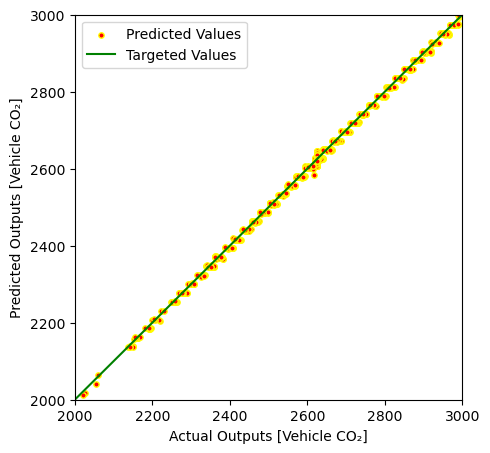

In [12]:
%%time
# Get the features from the test set
test_features = test_ft
# Get the actual CO2 output for the test set 
actual_labels = test_lbl

# Make prediction on the test set
predicted_labels = model.predict(x=test_features).flatten()

# Define the graph
Figure1 = plt.figure(figsize=(5,5), dpi=100)
plt.xlabel('Actual Outputs [Vehicle CO\u2082]')
plt.ylabel('Predicted Outputs [Vehicle CO\u2082]')
plt.scatter(actual_labels, predicted_labels, s=15, c='Red', edgecolors='Yellow', label='Predicted Values')

# Take the output data from 2000 to 3000 as an instance to visualize 
lims = [2000, 3000]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, color='Green', label='Targeted Values')
plt.legend()


### Error Count Histogram

Text(0, 0.5, 'Count')

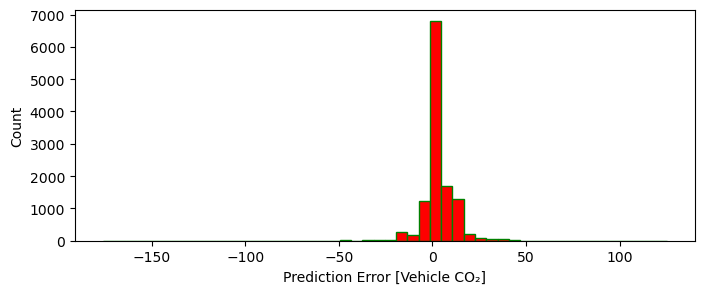

In [13]:
error = actual_labels - predicted_labels
Figure2 = plt.figure(figsize=(8,3), dpi=100)
plt.hist(error, bins=50, color='Red', edgecolor='Green')
plt.xlabel('Prediction Error [Vehicle CO\u2082]')
plt.ylabel('Count')

### Table of Actual and Predicted Values
Below, a table puts the actual and predicted values side by side. Html is used in this case. 

In [14]:
from IPython.display import HTML, display

def display_table(data_x, data_y):
    html = "<table>"
    html += "<tr>"
    html += "<td><h3>%s</h3><td>"%"Actual Vehicle CO\u2082"
    html += "<td><h3>%s</h3><td>"%"Predicted Vehicle CO\u2082"
    html += "</tr>"
    for i in range(len(data_x)):
        html += "<tr>"
        html += "<td><h4>%s</h4><td>"%(int(data_x[i]))
        html += "<td><h4>%s</h4><td>"%(int(data_y[i]))
        html += "</tr>"
    html += "</table>"
    display(HTML(html))
    
display_table(actual_labels[0:100], predicted_labels[0:100])